<a href="https://colab.research.google.com/github/Hunter-R-S/MAT494/blob/main/NeuralNetworksipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MAT 494 - Neural Networks**

The below is an example of working with neural networks. It comes from QuantEcon's lecture series on Python.

In [5]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader.data as web

from sklearn import (
    linear_model, metrics, neural_network, pipeline, preprocessing, model_selection
)

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
start = "1974-01-01"
end = datetime.date.today()

def pct_change_on_last_year(df):
    "compute pct_change on previous year, assuming quarterly"
    return (df - df.shift(4))/df.shift(4)

def get_indicators_from_fred(start=start, end=end):
    """
    Fetch quarterly data on 6 leading indicators from time period start:end
    """
    # yield curve, unemployment, change in inventory, new private housing permits
    yc_unemp_inv_permit = (
        web.DataReader(["T10Y2Y", "UNRATE", "CBIC1", "PERMIT"], "fred", start, end)
        .resample("QS")
        .mean()
    )

    # percent change in housing prices and retail sales
    hpi_retail = (
        web.DataReader(["USSTHPI", "SLRTTO01USQ661S"], "fred", start, end)
        .resample("QS")  # already quarterly, adjusting so index is same
        .mean()
        .pipe(pct_change_on_last_year)
        .dropna()
    )

    indicators = (
        yc_unemp_inv_permit
        .join(hpi_retail)
        .dropna()
        .rename(columns=dict(
            USSTHPI="pct_change_hpi",
            T10Y2Y="yield_curve",
            UNRATE="unemp",
            CBIC1="inventory",
            SLRTTO01USQ661S="retail_sales",
            PERMIT="house_permits"
        ))
    )

    return indicators

indicators = get_indicators_from_fred()

indicators.head()

,yield_curve,unemp,inventory,house_permits,pct_change_hpi,retail_sales
DATE,,,,,,
1976-04-01,0.801364,7.566667,61.087,1171.333333,0.073303,0.056936
1976-07-01,1.099687,7.733333,55.190,1345.000000,0.088158,0.037207
1976-10-01,1.467377,7.766667,20.163,1489.000000,0.080360,0.047523
1977-01-01,1.332222,7.500000,34.343,1562.000000,0.105648,0.037939
1977-04-01,1.248254,7.133333,51.245,1693.333333,0.111230,0.032931


In [7]:
def get_recession_data():
    recession = (
        web.DataReader(["USRECQ"], "fred", start, end)
        .rename(columns=dict(USRECQ="recession"))
        ["recession"]
    )

    # extract start and end date for each recession
    start_dates = recession.loc[recession.diff() > 0].index.tolist()
    if recession.iloc[0] > 0:
        start_dates = [recession.index[0]] + start_dates

    end_dates = recession.loc[recession.diff() < 0].index.tolist()

    if (len(start_dates) != len(end_dates)) and (len(start_dates) != len(end_dates) + 1):
        raise ValueError("Need to have same number of start/end dates!")

    return recession, start_dates, end_dates

recession, start_dates, end_dates = get_recession_data()

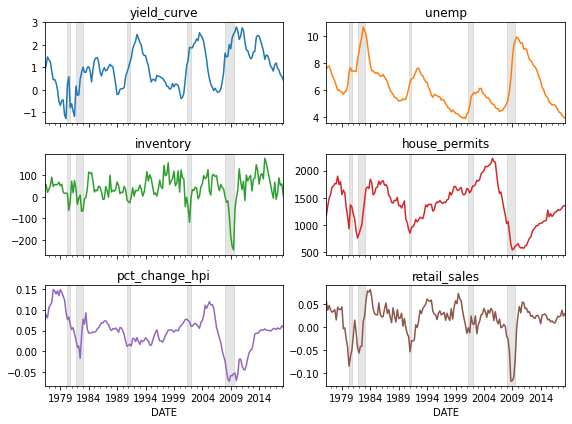

In [8]:
def add_recession_bands(ax):
    for s, e in zip(start_dates, end_dates):
        ax.axvspan(s, e, color="grey", alpha=0.2)

axs = indicators.plot(subplots=True, figsize=(8, 6), layout=(3, 2), legend=False)

for i, ax in enumerate(axs.flatten()):
    add_recession_bands(ax)
    ax.set_title(list(indicators)[i])

fig = axs[0, 0].get_figure()
fig.tight_layout();